In [17]:
# Standard two-firm Hotelling (no procurement)
# --------------------------------------------
import numpy as np

def Sb_vs_rival(Pb, Pg, vb, vg, alpha, t):
    """Brand share vs generic under Hotelling."""
    return 0.5 + (vb - alpha*Pb - vg + alpha*Pg) / (2*t)

def standard_duopoly_equilibrium(alpha, t, vb, vg, MCb, MCg):
    """
    Solve the 2x2 best-response system:
      Pb = (t + vb - vg)/(2α) + 0.5*Pg + 0.5*MCb
      Pg = (t + vg - vb)/(2α) + 0.5*Pb + 0.5*MCg
    Returns dict with Pb, Pg, shares, and profits.
    """
    A = np.array([[1.0, -0.5],
                  [-0.5, 1.0]], dtype=float)
    b = np.array([
        (t + vb - vg)/(2*alpha) + 0.5*MCb,
        (t + vg - vb)/(2*alpha) + 0.5*MCg
    ], dtype=float)
    Pb, Pg = np.linalg.solve(A, b)

    Sb = Sb_vs_rival(Pb, Pg, vb, vg, alpha, t)
    Sg = 1.0 - Sb
    prof_b = (Pb - MCb) * Sb
    prof_g = (Pg - MCg) * Sg
    return {"Pb": Pb, "Pg": Pg, "Sb": Sb, "Sg": Sg,
            "profit_b": prof_b, "profit_g": prof_g}

# ---- Example: edit these numbers to taste ----
alpha = 0.1
t     = 8
vb    = 74.815
vg    = 70
MCb   = 18.36
MCg   = 13.09

res = standard_duopoly_equilibrium(alpha, t, vb, vg, MCb, MCg)
for k, v in res.items():
    print(f"{k:>10s}: {v:.6f}")


        Pb: 112.653333
        Pg: 78.796667
        Sb: 0.589333
        Sg: 0.410667
  profit_b: 55.570204
  profit_g: 26.983538


In [28]:
# Three-firm Salop (B vs G1 vs G2) — pairwise arc-split with clipping
# -------------------------------------------------------------------
import numpy as np

def _arc_split(Vi, pi, Vj, pj, alpha, t, L=1/3):
    """
    On an arc (length L) from firm i to firm j (neighbors on the circle),
    the indifferent point measured from i toward j lies at:
        s_raw = ( (Vi - α*pi) - (Vj - α*pj) + t*L ) / (2t)
    Clamp to [0, L]. Return (length_for_i, length_for_j).
    """
    s_raw = ((Vi - alpha*pi) - (Vj - alpha*pj) + t*L) / (2*t)
    s = min(max(s_raw, 0.0), L)
    return s, L - s

def shares_salop_three(pb, pg1, pg2, vb, vg, alpha, t):
    """
    Robust Salop shares using pairwise arc-splits (equal spacing L=1/3):
      arcs: B—G1, G1—G2, G2—B   (wrap-around)
    Returns qb, qg1, qg2 >= 0 summing to 1 (up to fp error).
    """
    L = 1.0/3.0

    # Arc B → G1
    b_BG1, g1_BG1 = _arc_split(vb, pb, vg, pg1, alpha, t, L=L)
    # Arc G1 → G2
    g1_G1G2, g2_G1G2 = _arc_split(vg, pg1, vg, pg2, alpha, t, L=L)
    # Arc G2 → B  (wrap-around)
    g2_G2B, b_G2B = _arc_split(vg, pg2, vb, pb, alpha, t, L=L)

    qb  = b_BG1 + b_G2B
    qg1 = g1_BG1 + g1_G1G2
    qg2 = g2_G1G2 + g2_G2B

    S = qb + qg1 + qg2
    if S <= 0:
        # extremely degenerate; fall back equal split
        qb = qg1 = qg2 = 1.0/3.0
    else:
        qb, qg1, qg2 = qb/S, qg1/S, qg2/S
    return qb, qg1, qg2

def salop_three_equilibrium(alpha, t, vb, vg, c_b, c_g):
    """
    Solve the 3x3 interior best-response system for prices with one brand (B) and
    two symmetric generics (G1,G2):
      pb  = (vb-vg)/(2α) + 0.5*c_b + 0.25*(pg1+pg2) + t/(6α)
      pg1 = (vg-vb)/(4α) + 0.5*c_g + 0.25*(pb+pg2) + t/(6α)
      pg2 = (vg-vb)/(4α) + 0.5*c_g + 0.25*(pb+pg1) + t/(6α)

    NOTE: This linear system characterizes the *interior* BR fixed point.
    We then compute *robust shares* via pairwise arc-splits with clipping.
    If clipping binds, true global equilibrium might require KKT/corner checks.
    """
    A = np.array([
        [1.0, -0.25, -0.25],
        [-0.25, 1.0, -0.25],
        [-0.25, -0.25, 1.0]
    ], dtype=float)

    b1 = (vb - vg)/(2*alpha) + 0.5*c_b + t/(6*alpha)
    b2 = (vg - vb)/(4*alpha) + 0.5*c_g + t/(6*alpha)
    b = np.array([b1, b2, b2], dtype=float)

    pb, pg1, pg2 = np.linalg.solve(A, b)

    # Robust shares (pairwise + clipping)
    qb, qg1, qg2 = shares_salop_three(pb, pg1, pg2, vb, vg, alpha, t)

    prof_b  = (pb  - c_b) * qb
    prof_g1 = (pg1 - c_g) * qg1
    prof_g2 = (pg2 - c_g) * qg2

    return {
        "pb": pb, "pg1": pg1, "pg2": pg2,
        "qb": qb, "qg1": qg1, "qg2": qg2,
        "profit_b": prof_b, "profit_g1": prof_g1, "profit_g2": prof_g2
    }

# ---- Example ----
if __name__ == "__main__":
    alpha = 0.1
    t     = 21.74
    vb    = 74.815
    vg    = 70.0
    c_b   = 18.36
    c_g   = 13.09

    out = salop_three_equilibrium(alpha, t, vb, vg, c_b, c_g)
    for k, v in out.items():
        print(f"{k:>12s}: {v:.6f}")


          pb: 107.978667
         pg1: 76.980667
         pg2: 76.980667
          qb: 0.412229
         qg1: 0.293885
         qg2: 0.293885
    profit_b: 36.943447
   profit_g1: 18.776528
   profit_g2: 18.776528


In [2]:
# ======================================================================
# Procurement + Retail Hotelling model
# Robust indifference equilibrium + full printout + plots
# ======================================================================

from dataclasses import dataclass
from typing import Tuple, Dict
import numpy as np
import matplotlib.pyplot as plt

# --------------------------
# Core parameter containers
# --------------------------
@dataclass
class Common:
    alpha: float
    t: float
    vb: float
    MCb: float
    A: float
    tau: float = 0.5  # only used for exact price ties in BR intersection fallback

@dataclass
class Gen:
    name: str
    vg: float
    MCg: float

# --------------------------
# Hotelling primitives
# --------------------------
def Xp(Pb: float, Pp: float, vb: float, vp: float, alpha: float, t: float) -> float:
    """Share of the procurement winner p vs brand at (Pb,Pp)."""
    return 0.5 + (vp - alpha*Pp - vb + alpha*Pb)/(2*t)

def Sb_vs_rival(Pb: float, Pr: float, vb: float, vr: float, alpha: float, t: float) -> float:
    """Brand share vs rival r=(vr,Pr)."""
    return 0.5 + (vb - alpha*Pb - vr + alpha*Pr)/(2*t)

def Pg_BR_given_Pb(Pb: float, vg: float, vb: float, MCg: float, alpha: float, t: float) -> float:
    """Loser generic's best response price to Pb (standard Hotelling BR)."""
    return (t + vg - vb)/(2*alpha) + 0.5*Pb + 0.5*MCg

# --------------------------
# Brand FOC and solver (Stage 2)
# --------------------------
def brand_foc(Pb: float, Pp: float, *, vb: float, vp: float, vg: float,
              MCb: float, MCg: float, A: float, alpha: float, t: float) -> float:
    xp = Xp(Pb, Pp, vb, vp, alpha, t)
    xp = max(min(xp, 1.0 - 1e-9), 1e-9)
    w  = A / xp

    Sb_p = Sb_vs_rival(Pb, Pp, vb, vp, alpha, t)
    Pg   = Pg_BR_given_Pb(Pb, vg, vb, MCg, alpha, t)
    Sb_g = Sb_vs_rival(Pb, Pg, vb, vg, alpha, t)

    H = w*Sb_p + (1 - w)*Sb_g

    dSb_dPb = -alpha/(2*t)
    dXp_dPb =  alpha/(2*t)
    dw_dPb  = -A * dXp_dPb / (xp**2)
    Delta   = Sb_p - Sb_g
    Hprime  = dSb_dPb + dw_dPb * Delta

    return H + (Pb - MCb) * Hprime

def solve_brand_price(Pp: float, *, vb: float, vp: float, vg: float,
                      MCb: float, MCp: float, MCg: float, A: float,
                      alpha: float, t: float,
                      bracket: Tuple[float, float]=(0.0, 200.0),
                      tol: float=1e-8, maxit: int=200) -> Tuple[float, Dict]:
    """Solve Pb* given winner (vp,MCp) and loser (vg,MCg). Enforces corner A>=Xp and Pb>=0."""
    f = lambda x: brand_foc(x, Pp, vb=vb, vp=vp, vg=vg, MCb=MCb, MCg=MCg, A=A, alpha=alpha, t=t)
    lo, hi = bracket
    fl, fh = f(lo), f(hi)
    expand = 0
    while np.sign(fl) == np.sign(fh) and expand < 8:
        hi *= 2.0; fh = f(hi); expand += 1

    used_interior, iters, Pb_int = False, 0, None
    if np.isfinite(fl) and np.isfinite(fh) and np.sign(fl) != np.sign(fh):
        used_interior = True
        for iters in range(maxit):
            mid = 0.5*(lo+hi); fm = f(mid)
            if abs(fm) < tol or (hi-lo) < tol:
                Pb_int = mid; break
            if np.sign(fl)*np.sign(fm) <= 0:
                hi, fh = mid, fm
            else:
                lo, fl = mid, fm
        else:
            Pb_int = mid

    # Corner candidate (Brand vs winner only)
    Pb_corner = (t + vb - vp)/(2*alpha) + 0.5*Pp + 0.5*MCb
    Pb_star   = Pb_int if Pb_int is not None else Pb_corner

    # Corner: if A >= Xp(Pb*), use corner price (residual mass zero)
    xp_star = Xp(Pb_star, Pp, vb, vp, alpha, t)
    if A >= xp_star:
        Pb_star = Pb_corner

    Pb_star = max(0.0, Pb_star)
    info = dict(Pb_interior=Pb_int, used_interior=used_interior,
                iterations=iters, Pb_corner=Pb_corner)
    return Pb_star, info

# --------------------------
# Stage-2 outcomes at given Pp and winner/loser mapping
# --------------------------
def stage2_outcomes_given_winner(Pp: float, *, common: Common, winner: Gen, loser: Gen) -> Dict:
    Pb, info = solve_brand_price(Pp,
                                 vb=common.vb, vp=winner.vg, vg=loser.vg,
                                 MCb=common.MCb, MCp=winner.MCg, MCg=loser.MCg,
                                 A=common.A, alpha=common.alpha, t=common.t)
    xp = Xp(Pb, Pp, common.vb, winner.vg, common.alpha, common.t)
    residual_mass = max(1.0 - common.A / max(xp, 1e-12), 0.0)

    # Loser BR to brand
    Pg = Pg_BR_given_Pb(Pb, loser.vg, common.vb, loser.MCg, common.alpha, common.t)
    Sb_res = Sb_vs_rival(Pb, Pg, common.vb, loser.vg, common.alpha, common.t)
    Sg_res = 1.0 - Sb_res

    return dict(Pb=Pb, Pg=Pg, xp=xp, residual_mass=residual_mass,
                Sb_residual=Sb_res, Sg_residual=Sg_res,
                profit_brand_retail=(Pb-common.MCb)*(residual_mass*Sb_res),
                profit_loser=(Pg-loser.MCg)*(residual_mass*Sg_res),
                profit_winner_tranche=common.A*(Pp - winner.MCg),
                solver_info=info)

# --------------------------
# (Optional) BR + intersection (fallback)
# --------------------------
def expected_profit_generic_i(Pi: float, Pj: float, *, i: Gen, j: Gen, common: Common) -> float:
    if Pi < Pj:
        return common.A * (Pi - i.MCg)  # win tranche
    elif Pi > Pj:
        out = stage2_outcomes_given_winner(Pj, common=common, winner=j, loser=i)
        return out["profit_loser"]
    else:
        win_prob = common.tau if i.name == "g1" else (1-common.tau)
        tranche = common.A * (Pi - i.MCg)
        out_lose = stage2_outcomes_given_winner(Pj, common=common, winner=j, loser=i)["profit_loser"]
        return win_prob * tranche + (1-win_prob) * out_lose

def generic_br_curve(P_rival_grid: np.ndarray, *, me: Gen, rival: Gen, common: Common,
                     Pi_bounds: Tuple[float, float]) -> Tuple[np.ndarray, np.ndarray]:
    low0, high0 = Pi_bounds
    BR = np.zeros_like(P_rival_grid); profits = np.zeros_like(P_rival_grid)
    for k, Pj in enumerate(P_rival_grid):
        low, high = low0, high0; span = high - low
        best_Pi, best_val = None, -1e300
        for res in [400, 200, 100, 50]:
            grid = np.linspace(low, high, res)
            vals = [expected_profit_generic_i(pi, Pj, i=me, j=rival, common=common) for pi in grid]
            idx = int(np.argmax(vals))
            best_Pi, best_val = grid[idx], float(vals[idx])
            if res > 50:
                half = span / res
                low  = max(low0,  best_Pi - 5*half)
                high = min(high0, best_Pi + 5*half)
                span = high - low
        BR[k], profits[k] = best_Pi, best_val
    return BR, profits

def auction_equilibrium(common: Common, g1: Gen, g2: Gen,
                        bid_bounds=(0.05,80), ngrid=200) -> Dict:
    grid = np.linspace(bid_bounds[0], bid_bounds[1], ngrid)
    BR1_y, _ = generic_br_curve(grid, me=g1, rival=g2, common=common, Pi_bounds=bid_bounds)
    BR2_y, _ = generic_br_curve(grid, me=g2, rival=g1, common=common, Pi_bounds=bid_bounds)
    curve1 = np.column_stack([grid, BR1_y])      # (P2, P1)
    curve2 = np.column_stack([BR2_y, grid])      # (P2, P1)
    Dmin, i_star, j_star = 1e300, None, None
    for i in range(len(curve1)):
        diffs = curve2 - curve1[i]
        dists = np.sqrt(np.sum(diffs**2, axis=1))
        j = int(np.argmin(dists))
        if dists[j] < Dmin:
            Dmin, i_star, j_star = dists[j], i, j
    P2_star, P1_star = curve1[i_star]
    for _ in range(20):
        P1_star = generic_br_curve(np.array([P2_star]), me=g1, rival=g2, common=common, Pi_bounds=bid_bounds)[0][0]
        P2_star = generic_br_curve(np.array([P1_star]), me=g2, rival=g1, common=common, Pi_bounds=bid_bounds)[0][0]
    if P1_star < P2_star:
        winner, loser = g1, g2
    elif P2_star < P1_star:
        winner, loser = g2, g1
    else:
        winner, loser = (g1, g2)  # deterministic if perfectly equal
    Pp_star = min(P1_star, P2_star)
    return dict(P1_star=P1_star, P2_star=P2_star, Pp_star=Pp_star, winner=winner.name)

# --------------------------
# Indifference equilibrium (robust)
# --------------------------
def _indiff_three(me: Gen, rival: Gen, common: Common,
                  bounds=(0.01, 80.0), tol: float = 1e-10, maxit: int = 200):
    """
    Guaranteed 3-tuple output: (P_star, status, details).
    """
    def f(P):
        win  = common.A * (P - me.MCg)
        lose = stage2_outcomes_given_winner(P, common=common, winner=rival, loser=me)["profit_loser"]
        return win - lose

    xs = np.linspace(bounds[0], bounds[1], 800)
    fs = np.array([f(x) for x in xs])
    idx = np.where(np.sign(fs[:-1])*np.sign(fs[1:]) < 0)[0]
    if len(idx) == 0:
        return None, "no_root_on_interval", {"scan_x": xs, "scan_f": fs}

    a, b = xs[idx[0]], xs[idx[0]+1]
    fa, fb = f(a), f(b)
    for _ in range(maxit):
        m = 0.5*(a+b); fm = f(m)
        if abs(fm) < tol or (b-a) < tol:
            return m, "ok", {"bracket": (a,b)}
        if fa*fm <= 0: b, fb = m, fm
        else:          a, fa = m, fm
    return m, "maxit", {"bracket": (a,b)}

def equilibrium_by_indifference(common: Common, g1: Gen, g2: Gen,
                                bounds=(0.01, 80.0), tol_equal: float = 1e-6):
    P1_dag, s1, _ = _indiff_three(g1, g2, common, bounds=bounds)
    P2_dag, s2, _ = _indiff_three(g2, g1, common, bounds=bounds)

    out = {"P1_dagger": P1_dag, "P2_dagger": P2_dag, "status_g1": s1, "status_g2": s2}

    def pack(mode, Pp, winner_obj, loser_obj, reason):
        st2 = stage2_outcomes_given_winner(Pp, common=common, winner=winner_obj, loser=loser_obj)
        out.update({
            "mode": mode, "Pp_star": Pp, "winner": winner_obj.name, "loser": loser_obj.name, "reason": reason,
            "Pb_star": st2["Pb"], "Pg_star": st2["Pg"], "Xp": st2["xp"], "residual_mass": st2["residual_mass"],
            "Sb_residual": st2["Sb_residual"], "Sg_residual": st2["Sg_residual"],
            "profit_winner_tranche": st2["profit_winner_tranche"],
            "profit_loser_retail": st2["profit_loser"],
            "profit_brand_retail": st2["profit_brand_retail"],
        })
        return out

    if s1 == "ok" and s2 == "ok" and (P1_dag is not None) and (P2_dag is not None):
        if abs(P1_dag - P2_dag) <= tol_equal:
            Pp = 0.5*(P1_dag + P2_dag)
            return pack("indifference", Pp, g1, g2, f"Equal daggers (|Δ|≤{tol_equal}).")
        else:
            Pp = max(P1_dag, P2_dag)
            if P1_dag < P2_dag:
                return pack("indifference", Pp, g1, g2, "Different daggers: Pp=max{P1†,P2†}; lower-† firm wins.")
            else:
                return pack("indifference", Pp, g2, g1, "Different daggers: Pp=max{P1†,P2†}; lower-† firm wins.")

    # Fallback: BR-intersection (uniform output)
    eq_br = auction_equilibrium(common, g1, g2, bid_bounds=bounds, ngrid=400)
    winner_obj = g1 if eq_br["winner"] == "g1" else g2
    loser_obj  = g2 if eq_br["winner"] == "g1" else g1
    return pack("fallback_br", eq_br["Pp_star"], winner_obj, loser_obj,
                "Indifference root missing on bounds; using BR-intersection.")

# --------------------------
# Pretty print + Plots
# --------------------------
def print_equilibrium_summary(common: Common, g1: Gen, g2: Gen,
                              bounds=(0.01, 80.0), tol_equal: float = 1e-6):
    eq = equilibrium_by_indifference(common, g1, g2, bounds=bounds, tol_equal=tol_equal)

    print("=== Indifference bids ===")
    print(f"P1† (g1 vs g2): {eq['P1_dagger']}  status: {eq['status_g1']}")
    print(f"P2† (g2 vs g1): {eq['P2_dagger']}  status: {eq['status_g2']}")
    print(f"\n=== Equilibrium ({eq['mode']}) ===")
    print(eq["reason"])
    print(f"Pp* (procurement price): {eq['Pp_star']}")
    print(f"Winner: {eq['winner']}   Loser: {eq['loser']}")
    print("\nStage-2 outcomes at Pp*:")
    print(f"  Pb* (brand):      {eq['Pb_star']}")
    print(f"  Pg* (loser):      {eq['Pg_star']}")
    print(f"  Xp (p vs brand):  {eq['Xp']}")
    print(f"  Residual mass:    {eq['residual_mass']}")
    print(f"  S_b residual:     {eq['Sb_residual']}")
    print(f"  S_g residual:     {eq['Sg_residual']}")
    print("Profits:")
    print(f"  Winner tranche:   {eq['profit_winner_tranche']}")
    print(f"  Loser (retail):   {eq['profit_loser_retail']}")
    print(f"  Brand (retail):   {eq['profit_brand_retail']}")

def delta_win_minus_lose(me: Gen, rival: Gen, common: Common, P: float) -> float:
    win  = common.A * (P - me.MCg)
    lose = stage2_outcomes_given_winner(P, common=common, winner=rival, loser=me)["profit_loser"]
    return win - lose

def best_response_eps(Pj: float, *, me: Gen, rival: Gen, common: Common, eps: float=1e-3) -> float:
    d = delta_win_minus_lose(me, rival, common, Pj)
    if d > 0:   return max(0.0, Pj - eps)  # prefers to win
    if d < 0:   return Pj + eps            # prefers to lose
    return Pj                              # indifferent


def plot_curves_with_equilibrium(common: Common, g1: Gen, g2: Gen,
                                 bounds=(0.01, 80.0), eps=1e-3, N=600, margin=5):
    # Find equilibrium and indifference points first
    eq = equilibrium_by_indifference(common, g1, g2, bounds=bounds)
    Pp_star = eq["Pp_star"]
    P1_dag, P2_dag = eq["P1_dagger"], eq["P2_dagger"]

    lo, hi = bounds

    # ----- x-range for Δ(P): go to max(daggers, Pp*) + margin, not capped by 'hi' -----
    if (P1_dag is not None) and (P2_dag is not None):
        hi_plot = max(P1_dag, P2_dag)
    elif (P1_dag is not None) or (P2_dag is not None):
        hi_plot = (P1_dag or P2_dag)
    else:
        hi_plot = hi  # no indifference points found → use bounds

    # also make sure we include Pp* and add margin
    hi_plot = max(hi_plot, Pp_star) + margin

    Ps = np.linspace(lo, hi_plot, N)

    # ----- Panel A: Δ(P) curves -----
    d1 = np.array([delta_win_minus_lose(g1, g2, common, P) for P in Ps])
    d2 = np.array([delta_win_minus_lose(g2, g1, common, P) for P in Ps])

    plt.figure(figsize=(6.4,3.9))
    plt.plot(Ps, d1, label="Δ₁(P) = Win₁ − Lose₁")
    plt.plot(Ps, d2, label="Δ₂(P) = Win₂ − Lose₂")
    plt.axhline(0, color='k', lw=0.8)
    if P1_dag is not None: plt.axvline(P1_dag, ls='--', label=f"g1 P†≈{P1_dag:.2f}")
    if P2_dag is not None: plt.axvline(P2_dag, ls='--', label=f"g2 P†≈{P2_dag:.2f}")
    plt.axvline(Pp_star, color='k', ls=':', label=f"Pp*≈{Pp_star:.2f}")
    plt.title("Win–Lose Advantage Δ(P)")
    plt.xlabel("Price P"); plt.ylabel("Δ(P)")
    plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

    # ----- Panel B: ε-BR curves (keep original bounds for comparability) -----
    Ps_br = np.linspace(lo, hi, N)
    BR1 = np.array([best_response_eps(P, me=g1, rival=g2, common=common, eps=eps) for P in Ps_br])
    BR2 = np.array([best_response_eps(P, me=g2, rival=g1, common=common, eps=eps) for P in Ps_br])

    plt.figure(figsize=(6.4,5.0))
    plt.plot(Ps_br, BR1, label=r"$\mathrm{BR}_{g1}: P_1^*(P_2)$ (ε-BR)")
    plt.plot(BR2, Ps_br, label=r"$\mathrm{BR}_{g2}: P_2^*(P_1)$ (ε-BR)")
    P1_at_Pp = best_response_eps(Pp_star, me=g1, rival=g2, common=common, eps=eps)
    P2_at_Pp = best_response_eps(Pp_star, me=g2, rival=g1, common=common, eps=eps)
    plt.scatter([Pp_star], [P1_at_Pp], color='C0', zorder=5, label=f"g1 BR at Pp*")
    plt.scatter([P2_at_Pp], [Pp_star], color='C1', zorder=5, label=f"g2 BR at Pp*")
    if P1_dag is not None: plt.axvline(P1_dag, ls=':', color='gray')
    if P2_dag is not None: plt.axvline(P2_dag, ls=':', color='gray')
    plt.axvline(Pp_star, color='k', ls=':', alpha=0.8)
    plt.xlabel(r"Rival bid $P_2$"); plt.ylabel(r"Own bid $P_1$")
    plt.title(f"Best-Response Curves with ε={eps}   (winner: {eq['winner']})")
    plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

=== Indifference bids ===
P1† (g1 vs g2): 17.304867909031366  status: ok
P2† (g2 vs g1): 17.304867909031366  status: ok

=== Equilibrium (indifference) ===
Equal daggers (|Δ|≤1e-06).
Pp* (procurement price): 17.304867909031366
Winner: g1   Loser: g2

Stage-2 outcomes at Pp*:
  Pb* (brand):      103.3214271068573
  Pg* (loser):      74.13071355342866
  Xp (p vs brand):  0.7366659949864118
  Residual mass:    0.11764625430825049
  S_b residual:     0.6184955402910709
  S_g residual:     0.3815044597089291
Profits:
  Winner tranche:   2.7396641408703877
  Loser (retail):   2.739664140825217
  Brand (retail):   6.182106402043174


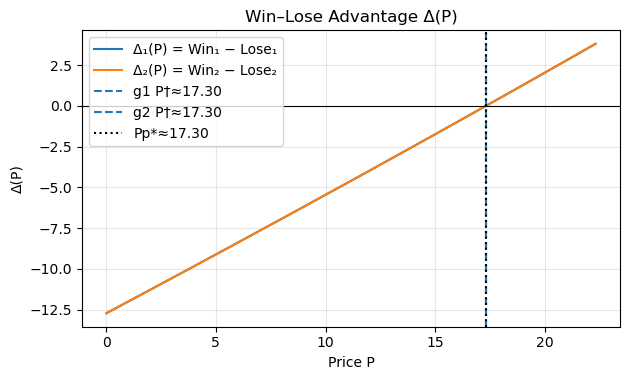

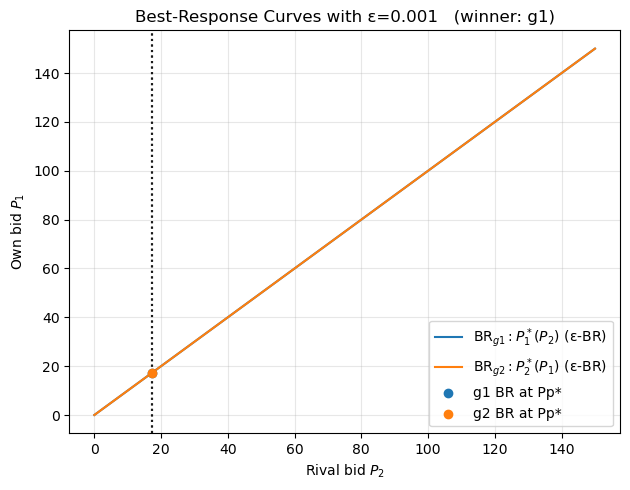

In [3]:
# =========================
# --- EDIT THESE NUMBERS ---
# =========================
common = Common(alpha=0.1, t=8, vb=74.815, MCb=18.36, A=0.65, tau=0.5)

# Symmetric example:
g1 = Gen(name="g1", vg=70.0, MCg=13.09)
g2 = Gen(name="g2", vg=70.0, MCg=13.09)


print_equilibrium_summary(common, g1, g2, bounds=(0.01, 150.0), tol_equal=1e-6)
plot_curves_with_equilibrium(common, g1, g2, bounds=(0.01, 150.0), eps=1e-3, N=600)

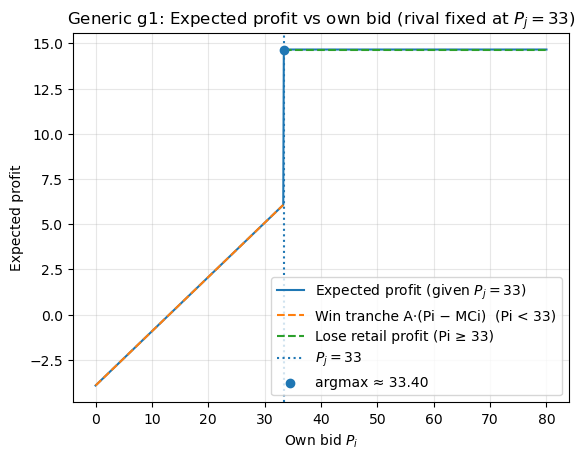

Max on grid at Pi ≈ 33.4000, expected profit ≈ 14.656652
(Lose-profit at Pj=15 is ≈ 14.656652)


In [31]:
# --- Expected profit vs own bid when rival's bid is fixed ---
import numpy as np
import matplotlib.pyplot as plt

# Choose who is "me" and who is the rival
me    = g1  # <- change to g2 if you want g2's curve
rival = g2   # <- and g1 here correspondingly

Pj_fixed = 33.35
Pi_grid  = np.linspace(0.0, 80.0, 801)  # 0 ... 80 in 0.1 steps

# Expected profit curve E[Pi | Pj=15]
prof_curve = np.array([
    expected_profit_generic_i(pi, Pj_fixed, i=me, j=rival, common=common)
    for pi in Pi_grid
])

# For intuition, also show the two components at Pj=15:
# - "Win by epsilon" tranche profit A*(Pi - MC_i) when Pi < Pj
# - "Lose on purpose" retail profit when Pi >= Pj (independent of Pi near Pj)
win_component  = np.where(Pi_grid < Pj_fixed, common.A * (Pi_grid - me.MCg), np.nan)
lose_component = stage2_outcomes_given_winner(Pp=Pj_fixed, common=common, winner=rival, loser=me)["profit_loser"]
lose_line      = np.where(Pi_grid >= Pj_fixed, lose_component, np.nan)

# Find argmax on the grid
imax = int(np.nanargmax(prof_curve))
Pi_star, prof_star = Pi_grid[imax], prof_curve[imax]

plt.figure()
plt.plot(Pi_grid, prof_curve, label="Expected profit (given $P_j=33$)")
plt.plot(Pi_grid, win_component,  linestyle="--", label="Win tranche A·(Pi − MCi)  (Pi < 33)")
plt.plot(Pi_grid, lose_line,      linestyle="--", label="Lose retail profit (Pi ≥ 33)")
plt.axvline(Pj_fixed, linestyle=":", label="$P_j=33$")
plt.scatter([Pi_star], [prof_star], zorder=5, label=f"argmax ≈ {Pi_star:.2f}")
plt.xlabel("Own bid $P_i$")
plt.ylabel("Expected profit")
plt.title(f"Generic {me.name}: Expected profit vs own bid (rival fixed at $P_j=33$)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Max on grid at Pi ≈ {Pi_star:.4f}, expected profit ≈ {prof_star:.6f}")
print(f"(Lose-profit at Pj=15 is ≈ {lose_component:.6f})")

In [20]:
# Indifference bid: solve for P where tranche profit equals loser retail profit
# Uses your existing Common/Gen objects and stage2_outcomes_given_winner()

def indifference_bid(me: Gen, rival: Gen, common: Common,
                     bounds=(0.01, 80.0), tol=1e-10, maxit=200):
    """
    Solve for P^dagger in [bounds] s.t.
        A*(P - MC_me)  =  profit_loser( when rival wins at P )
    Returns (P_star, status, details)
    """
    def f(P):
        win  = common.A * (P - me.MCg)  # tranche profit if me wins at P
        lose = stage2_outcomes_given_winner(P, common=common, winner=rival, loser=me)["profit_loser"]
        return win - lose

    lo, hi = bounds
    # coarse scan to bracket a root
    import numpy as np
    xs = np.linspace(lo, hi, 600)
    fs = np.array([f(x) for x in xs])
    idx = np.where(np.sign(fs[:-1]) * np.sign(fs[1:]) < 0)[0]
    if len(idx) == 0:
        return None, "no_root_on_interval", {"scan_x": xs, "scan_f": fs}

    a, b = xs[idx[0]], xs[idx[0]+1]
    fa, fb = f(a), f(b)

    # bisection
    for _ in range(maxit):
        m = 0.5*(a+b)
        fm = f(m)
        if abs(fm) < tol or (b-a) < tol:
            return m, "ok", {"bracket": (a, b), "fa": fa, "fb": fb}
        if fa * fm <= 0:
            b, fb = m, fm
        else:
            a, fa = m, fm
    return m, "maxit", {"bracket": (a, b), "fa": fa, "fb": fb}

# ---- Example run with your current parameters (symmetric) ----
P_star_g1, status1, det1 = indifference_bid(me=g1, rival=g2, common=common,
                                            bounds=(0.01, 80.0))
print(f"g1 indifference bid P^† ≈ {P_star_g1}  (status: {status1})")

P_star_g2, status2, det2 = indifference_bid(me=g2, rival=g1, common=common,
                                            bounds=(0.01, 80.0))
print(f"g2 indifference bid P^† ≈ {P_star_g2}  (status: {status2})")

# (Optional) verify continuity at P^† for g1
if status1 == "ok":
    P = P_star_g1
    win  = common.A * (P - g1.MCg)
    lose = stage2_outcomes_given_winner(P, common=common, winner=g2, loser=g1)["profit_loser"]
    print(f"At P^†: Win = {win:.6f}, Lose = {lose:.6f} (difference {win-lose:.2e})")


g1 indifference bid P^† ≈ None  (status: no_root_on_interval)
g2 indifference bid P^† ≈ None  (status: no_root_on_interval)


In [21]:
def indifference_bid(me: Gen, rival: Gen, common: Common,
                     bounds=(0.01, 80.0), tol=1e-10, maxit=200):
    import numpy as np
    def f(P):
        win  = common.A * (P - me.MCg)
        lose = stage2_outcomes_given_winner(P, common=common, winner=rival, loser=me)["profit_loser"]
        return win - lose

    xs = np.linspace(bounds[0], bounds[1], 800)
    fs = np.array([f(x) for x in xs])
    idx = np.where(np.sign(fs[:-1]) * np.sign(fs[1:]) < 0)[0]
    if len(idx) == 0:
        return None, "no_root"

    a, b = xs[idx[0]], xs[idx[0]+1]
    fa, fb = f(a), f(b)
    for _ in range(maxit):
        m = 0.5*(a+b); fm = f(m)
        if abs(fm) < tol or (b-a) < tol: return m, "ok"
        if fa*fm <= 0: b, fb = m, fm
        else: a, fa = m, fm
    return m, "maxit"

P1_dag, s1 = indifference_bid(g1, g2, common)
P2_dag, s2 = indifference_bid(g2, g1, common)
print("g1 indifference P†:", P1_dag, s1)
print("g2 indifference P†:", P2_dag, s2)

g1 indifference P†: None no_root
g2 indifference P†: None no_root


In [25]:
# ======================================================================
# NVBP Hotelling–Salop with:
#   • Scaled first market: s = min(1, A / q_p^(3))
#   • Residual (1-s) to B–G duopoly
#   • Loser optimizes Pg over BOTH markets when s < 1
#   • Simultaneous 3-firm Nash for (Pb,Pg) given Pp when s ≈ 1
#   • Indifference bidding with robust “always-win/lose” rules
# ======================================================================

from dataclasses import dataclass
from typing import Tuple, Dict
import numpy as np

# --------------------------
# Core parameter containers
# --------------------------
@dataclass
class Common:
    alpha: float
    t: float
    vb: float
    MCb: float
    A: float          # winner capacity (share out of total 1)
    tau: float = 0.5  # tie-break prob for g1 in exact ties

@dataclass
class Gen:
    name: str  # "g1" or "g2"
    vg: float
    MCg: float

# --------------------------
# 2-firm Hotelling (line)
# --------------------------
def Sb_vs_rival(Pb: float, Pr: float, vb: float, vr: float, alpha: float, t: float) -> float:
    """Brand share vs single rival on a line."""
    return 0.5 + (vb - alpha*Pb - vr + alpha*Pr) / (2*t)

# --------------------------
# Robust 3-firm Salop shares (with arc clipping)
# B — P — G — (back to B), equal arc length L=1/3
# --------------------------
def _arc_split(Vi, pi, Vj, pj, alpha, t, L=1/3):
    """Split neighbor arc i–j of length L; return (length_for_i, length_for_j) with clipping."""
    s_raw = ((Vi - alpha*pi) - (Vj - alpha*pj) + t*L) / (2*t)  # from i toward j
    s = min(max(s_raw, 0.0), L)
    return s, L - s

def shares_salop_three_prices(pb: float, pp: float, pg: float,
                              vb: float, vp: float, vg: float,
                              alpha: float, t: float):
    """
    Returns (qb, qp, qg) >= 0 summing to 1 (corner-safe).
    """
    L = 1.0/3.0
    bp_B, bp_P = _arc_split(vb, pb, vp, pp, alpha, t, L=L)  # along B→P
    pg_P, pg_G = _arc_split(vp, pp, vg, pg, alpha, t, L=L)  # along P→G
    gb_G, gb_B = _arc_split(vg, pg, vb, pb, alpha, t, L=L)  # along G→B

    qb = bp_B + gb_B
    qp = bp_P + pg_P
    qg = pg_G + gb_G
    S = qb + qp + qg
    if abs(S - 1.0) > 1e-12:
        qb, qp, qg = qb/S, qp/S, qg/S
    return qb, qp, qg

# --------------------------
# Simultaneous 3-firm Nash for (Pb,Pg) given Pp (no residual case)
# Linear 2x2 system of best responses
# --------------------------
def threefirm_prices_given_pp(Pp, *, vb, vg, cb, cg, alpha, t):
    """
    Solve the 2x2 BR system for (Pb, Pg) in 3-firm Salop with given Pp:
      Pb = (vb-vg)/(2α) + 0.5*cb + 0.25*(Pg+Pp) + t/(6α)
      Pg = (vg-vb)/(4α) + 0.5*cg + 0.25*(Pb+Pp) + t/(6α)
    """
    A = np.array([[1.0, -0.25],
                  [-0.25, 1.0]], dtype=float)
    b1 = (vb - vg)/(2*alpha) + 0.5*cb + 0.25*Pp + t/(6*alpha)
    b2 = (vg - vb)/(4*alpha) + 0.5*cg + 0.25*Pp + t/(6*alpha)
    Pb, Pg = np.linalg.solve(A, np.array([b1, b2], dtype=float))
    return float(Pb), float(Pg)

# --------------------------
# Loser optimizes Pg over BOTH markets (when s<1)
# --------------------------
def loser_total_profit(Pg: float, Pb: float, Pp: float, *,
                       vb: float, vp: float, vg: float,
                       cb: float, cg: float, A: float,
                       alpha: float, t: float):
    """
    Π_g(Pg|Pb,Pp) = (Pg-cg) * [ s*qg3 + (1-s)*(1 - S_b^duo(Pb,Pg)) ],
    with s = min(1, A/qp3) and (qb3,qp3,qg3) from 3-firm shares at (Pb,Pp,Pg).
    """
    qb3, qp3, qg3 = shares_salop_three_prices(Pb, Pp, Pg, vb, vp, vg, alpha, t)
    s = 0.0 if qp3 <= 1e-12 else min(1.0, A / qp3)
    residual = 1.0 - s
    if residual > 1e-12:
        Sb_duo = np.clip(Sb_vs_rival(Pb, Pg, vb, vg, alpha, t), 0.0, 1.0)
        qg_res = residual * (1.0 - Sb_duo)
    else:
        qg_res = 0.0
    qg_tot = s * qg3 + qg_res
    prof_g = (Pg - cg) * qg_tot
    return prof_g, dict(qb3=qb3, qp3=qp3, qg3=qg3, s=s, residual=residual, qg_total=qg_tot)

def optimize_loser_price(Pb: float, Pp: float, *,
                         vb: float, vp: float, vg: float,
                         cb: float, cg: float, A: float,
                         alpha: float, t: float,
                         bounds=(0.0, 200.0)):
    lo, hi = bounds
    bestPg, bestVal, bestInfo = None, -1e300, None
    for N in (401, 201, 101, 61, 31):
        grid = np.linspace(lo, hi, N)
        vals = []
        for Pg in grid:
            v, info = loser_total_profit(Pg, Pb, Pp, vb=vb, vp=vp, vg=vg,
                                         cb=cb, cg=cg, A=A, alpha=alpha, t=t)
            vals.append(v)
            if v > bestVal:
                bestVal, bestPg, bestInfo = v, Pg, info
        idx = int(np.argmax(vals))
        lo = max(bounds[0], grid[max(0, idx - 5)])
        hi = min(bounds[1], grid[min(N - 1, idx + 5)])
    return bestPg, dict(best_profit=bestVal, details=bestInfo, bracket_final=(lo, hi))

# --------------------------
# Brand profit for given Pb (loser optimizes Pg)
# --------------------------
def brand_profit_total(Pb: float, Pp: float, *,
                       vb: float, vp: float, vg: float,
                       MCb: float, MCg: float, A: float,
                       alpha: float, t: float) -> tuple:
    """
    Brand profit when loser best-responds on Pg by maximizing its total profit
    over BOTH markets (scaled first market + residual).
    Returns (brand_profit, Pg_opt, details_dict).
    """
    Pg_opt, opt_info = optimize_loser_price(
        Pb, Pp,
        vb=vb, vp=vp, vg=vg, cb=MCb, cg=MCg, A=A, alpha=alpha, t=t,
        bounds=(0.0, 200.0)
    )
    qb3, qp3, qg3 = opt_info["details"]["qb3"], opt_info["details"]["qp3"], opt_info["details"]["qg3"]
    s = opt_info["details"]["s"]
    residual = opt_info["details"]["residual"]

    qb1, qp1, qg1 = s*qb3, s*qp3, s*qg3
    if residual > 1e-12:
        Sb_duo = np.clip(Sb_vs_rival(Pb, Pg_opt, vb, vg, alpha, t), 0.0, 1.0)
        qb2 = residual * Sb_duo
        qg2 = residual * (1.0 - Sb_duo)
    else:
        qb2 = 0.0; qg2 = 0.0

    qb_total = qb1 + qb2
    qp_total = qp1                 # = min(A, qp3)
    qg_total = qg1 + qg2

    b_profit = (Pb - MCb) * qb_total

    details = dict(
        Pg_opt=Pg_opt, loser_opt_info=opt_info,
        qb3=qb3, qp3=qp3, qg3=qg3, s=s, residual_mass=residual,
        qb1=qb1, qp1=qp1, qg1=qg1, qb2=qb2, qg2=qg2,
        qb_total=qb_total, qp_total=qp_total, qg_total=qg_total
    )
    return b_profit, Pg_opt, details

# --------------------------
# Aggregate with scaled first market (utility/helper)
# --------------------------
def aggregate_with_scaled_first_market(Pb, Pp, Pg, *,
                                       vb, vp, vg, cb, cg, A, alpha, t):
    qb3, qp3, qg3 = shares_salop_three_prices(Pb, Pp, Pg, vb, vp, vg, alpha, t)
    s = 0.0 if qp3 <= 1e-12 else min(1.0, A/qp3)
    qb1, qp1, qg1 = s*qb3, s*qp3, s*qg3
    residual = 1.0 - s
    if residual > 1e-12:
        Sb_duo = np.clip(0.5 + (vb - alpha*Pb - vg + alpha*Pg)/(2*t), 0.0, 1.0)
        qb2 = residual*Sb_duo
        qg2 = residual*(1.0 - Sb_duo)
    else:
        qb2 = qg2 = 0.0
    qb_tot, qp_tot, qg_tot = qb1+qb2, qp1, qg1+qg2
    profit_b = (Pb - cb) * qb_tot
    profit_g = (Pg - cg) * qg_tot
    return {
        "qb3": qb3, "qp3": qp3, "qg3": qg3, "s": s, "residual": residual,
        "qb1": qb1, "qp1": qp1, "qg1": qg1, "qb2": qb2, "qg2": qg2,
        "qb_tot": qb_tot, "qp_tot": qp_tot, "qg_tot": qg_tot,
        "profit_b": profit_b, "profit_g": profit_g
    }

# --------------------------
# Brand price solver (used only when s < 1)
# --------------------------
def solve_brand_price_three_stage(Pp: float, *,
                                  vb: float, vp: float, vg: float,
                                  MCb: float, MCg: float, A: float,
                                  alpha: float, t: float,
                                  bracket: Tuple[float, float]=(0.0, 200.0)) -> tuple:
    lo, hi = bracket
    best_val, best_pb, best_pg, best_details = -1e300, None, None, None
    for N in (201, 81, 41):
        grid = np.linspace(lo, hi, N)
        vals = []
        for pb in grid:
            val, pg_used, details = brand_profit_total(
                pb, Pp,
                vb=vb, vp=vp, vg=vg,
                MCb=MCb, MCg=MCg, A=A,
                alpha=alpha, t=t
            )
            vals.append(val)
            if val > best_val:
                best_val, best_pb, best_pg, best_details = val, pb, pg_used, details
        idx = int(np.argmax(vals))
        lo = max(bracket[0], grid[max(0, idx - 5)])
        hi = min(bracket[1], grid[min(N - 1, idx + 5)])
    info = dict(best_profit=best_val, details=best_details, bracket_final=(lo, hi))
    return best_pb, best_pg, info

# --------------------------
# Stage-2 outcomes at given Pp (winner/loser known)
#   • If s≈1 under 3-firm Nash → use threefirm Nash (no residual)
#   • Else s<1 → use brand-solver with loser optimizing Pg
# --------------------------
def stage2_outcomes_given_winner(Pp: float, *, common: Common, winner: Gen, loser: Gen,
                                 tol_s: float = 1e-9) -> Dict:
    # Try pure 3-firm Nash first
    Pb_tf, Pg_tf = threefirm_prices_given_pp(
        Pp,
        vb=common.vb, vg=loser.vg, cb=common.MCb, cg=loser.MCg,
        alpha=common.alpha, t=common.t
    )
    agg_tf = aggregate_with_scaled_first_market(
        Pb_tf, Pp, Pg_tf,
        vb=common.vb, vp=winner.vg, vg=loser.vg, cb=common.MCb, cg=loser.MCg,
        A=common.A, alpha=common.alpha, t=common.t
    )
    if agg_tf["s"] >= 1.0 - 1e-6:
        # Pure 3-firm market: simultaneous Nash (no residual)
        return dict(
            Pb=Pb_tf, Pg=Pg_tf, Pp=Pp,
            qb_first=agg_tf["qb1"], qp_first=agg_tf["qp1"], qg_first=agg_tf["qg1"],
            qb_total=agg_tf["qb_tot"], qp_total=agg_tf["qp_tot"], qg_total=agg_tf["qg_tot"],
            residual_mass=agg_tf["residual"], binds=False,
            profit_brand_retail=agg_tf["profit_b"],
            profit_loser=agg_tf["profit_g"],
            profit_winner_tranche=common.A * (Pp - winner.MCg),
            solver_info={"mode": "three-firm-nash", "qb3": agg_tf["qb3"], "qp3": agg_tf["qp3"], "qg3": agg_tf["qg3"]}
        )

    # Otherwise capacity binds: brand chooses Pb (loser optimizes Pg internally)
    Pb, Pg, info = solve_brand_price_three_stage(
        Pp,
        vb=common.vb, vp=winner.vg, vg=loser.vg,
        MCb=common.MCb, MCg=loser.MCg, A=common.A,
        alpha=common.alpha, t=common.t,
        bracket=(0.0, 200.0)
    )
    agg = aggregate_with_scaled_first_market(
        Pb, Pp, Pg,
        vb=common.vb, vp=winner.vg, vg=loser.vg, cb=common.MCb, cg=loser.MCg,
        A=common.A, alpha=common.alpha, t=common.t
    )
    return dict(
        Pb=Pb, Pg=Pg, Pp=Pp,
        qb_first=agg["qb1"], qp_first=agg["qp1"], qg_first=agg["qg1"],
        qb_total=agg["qb_tot"], qp_total=agg["qp_tot"], qg_total=agg["qg_tot"],
        residual_mass=agg["residual"], binds=True,
        profit_brand_retail=agg["profit_b"],
        profit_loser=agg["profit_g"],
        profit_winner_tranche=common.A * (Pp - winner.MCg),
        solver_info={"mode": "capacity-binds-branch", "search_info": info,
                     "qb3": agg["qb3"], "qp3": agg["qp3"], "qg3": agg["qg3"], "s": agg["s"]}
    )

# --------------------------
# Procurement stage: indifference with robust rules
#   • If no Δ root and Δ>0 always → use upper bound
#   • If no Δ root and Δ<0 always → use MC
#   • else BR-intersection fallback
# --------------------------
def _indiff_three(me: Gen, rival: Gen, common: Common,
                  bounds=(0.01, 80.0), tol: float = 1e-10, maxit: int = 200,
                  max_expand: int = 4, expand_factor: float = 2.0,
                  max_fn_evals: int = 250):
    evals = 0
    def delta(P):
        nonlocal evals
        if evals >= max_fn_evals:
            # Force exit by returning current sign at upper bound
            return np.sign(delta_hi) if 'delta_hi' in locals() else 1.0
        evals += 1
        win  = common.A * (P - me.MCg)
        lose = stage2_outcomes_given_winner(P, common=common, winner=rival, loser=me)["profit_loser"]
        return win - lose

    lo, hi = bounds
    xs = np.linspace(lo, hi, 200)  # ↓ from 800 to 200
    fs = np.array([delta(x) for x in xs])
    # record signs at ends for fail-safe
    delta_lo, delta_hi = fs[0], fs[-1]
    idx = np.where(np.sign(fs[:-1]) * np.sign(fs[1:]) < 0)[0]
    if len(idx) == 0:
        lo2, hi2 = lo, hi
        for _ in range(max_expand):
            if evals >= max_fn_evals: break
            lo2 = max(0.0, lo2 / expand_factor)
            hi2 = hi2 * expand_factor
            xs2 = np.linspace(lo2, hi2, 200)
            fs2 = np.array([delta(x) for x in xs2])
            idx2 = np.where(np.sign(fs2[:-1]) * np.sign(fs2[1:]) < 0)[0]
            if len(idx2) > 0:
                a, b = xs2[idx2[0]], xs2[idx2[0] + 1]
                fa, fb = delta(a), delta(b)
                for _ in range(min(maxit, 60)):  # cap bisection steps
                    m = 0.5*(a+b); fm = delta(m)
                    if not np.isfinite(fm): fm = 0.0
                    if (abs(fm) < tol) or ((b-a) < tol): 
                        return m, "ok", {"bracket": (a,b), "used_bounds": (lo2,hi2), "evals": evals}
                    if fa*fm <= 0: b, fb = m, fm
                    else:          a, fa = m, fm
                return m, "maxit", {"bracket": (a,b), "used_bounds": (lo2,hi2), "evals": evals}
        # classify & return
        if np.all(np.isfinite(fs)) and np.max(np.abs(fs)) < 1e-6:
            return None, "flat", {"used_bounds": (lo,hi), "evals": evals}
        if np.all(fs > 0):
            return None, "always_win",  {"used_bounds": (lo,hi), "evals": evals}
        if np.all(fs < 0):
            return None, "always_lose", {"used_bounds": (lo,hi), "evals": evals}
        return None, "no_root_on_interval", {"used_bounds": (lo,hi),
                                             "minΔ": float(np.min(fs)), "maxΔ": float(np.max(fs)),
                                             "evals": evals}

    a, b = xs[idx[0]], xs[idx[0]+1]
    fa, fb = fs[idx[0]], fs[idx[0]+1]
    for _ in range(min(maxit, 60)):
        m = 0.5*(a+b); fm = delta(m)
        if not np.isfinite(fm): fm = 0.0
        if (abs(fm) < tol) or ((b-a) < tol):
            return m, "ok", {"bracket": (a,b), "used_bounds": bounds, "evals": evals}
        if fa*fm <= 0: b, fb = m, fm
        else:          a, fa = m, fm
    return m, "maxit", {"bracket": (a,b), "used_bounds": bounds, "evals": evals}

def equilibrium_by_indifference(common: Common, g1: Gen, g2: Gen,
                                bounds=(0.01, 80.0), tol_equal: float = 1e-6):
    P1_dag, s1, d1 = _indiff_three(g1, g2, common, bounds=bounds)
    P2_dag, s2, d2 = _indiff_three(g2, g1, common, bounds=bounds)
    out = {"P1_dagger": P1_dag, "P2_dagger": P2_dag,
           "status_g1": s1, "status_g2": s2, "diag_g1": d1, "diag_g2": d2}

    def cand(Pdag, status, details, me: Gen):
        if status == "ok" and (Pdag is not None):
            return Pdag, "ok"
        if status == "always_win":
            used = details.get("used_bounds", bounds)
            return used[1], "rule_upper_bound"
        if status == "always_lose":
            return me.MCg, "rule_mc"
        return None, status

    c1, why1 = cand(P1_dag, s1, d1, g1)
    c2, why2 = cand(P2_dag, s2, d2, g2)

    def pack(mode, Pp, w, l, reason):
        st2 = stage2_outcomes_given_winner(Pp, common=common, winner=w, loser=l)
        out.update({
            "mode": mode, "reason": reason, "Pp_star": Pp,
            "winner": w.name, "loser": l.name,
            "Pb_star": st2["Pb"], "Pg_star": st2["Pg"],
            "qb_first": st2["qb_first"], "qp_first": st2["qp_first"], "qg_first": st2["qg_first"],
            "qb_total": st2["qb_total"], "qp_total": st2["qp_total"], "qg_total": st2["qg_total"],
            "residual_mass": st2["residual_mass"], "binds": st2["binds"],
            "profit_winner_tranche": st2["profit_winner_tranche"],
            "profit_loser_retail": st2["profit_loser"],
            "profit_brand_retail": st2["profit_brand_retail"],
            "solver_info": st2["solver_info"],
        })
        return out

    if (c1 is not None) and (c2 is not None):
        if abs(c1 - c2) <= tol_equal:
            return pack("indifference_or_rule_tie", 0.5*(c1+c2), g1, g2,
                        f"Both candidates within tol (g1:{why1}, g2:{why2}).")
        Pp = max(c1, c2)
        if c1 < c2:
            return pack("indifference_or_rule", Pp, g1, g2,
                        f"Pp=max{{cand}}; lower candidate wins (g1:{why1}, g2:{why2}).")
        else:
            return pack("indifference_or_rule", Pp, g2, g1,
                        f"Pp=max{{cand}}; lower candidate wins (g1:{why1}, g2:{why2}).")

    reason = f"No usable candidate(s): g1={s1}/{why1}, g2={s2}/{why2}. Using BR-intersection."
    eq_br = auction_equilibrium(common, g1, g2, bid_bounds=bounds, ngrid=400)
    w = g1 if eq_br["winner"] == "g1" else g2
    l = g2 if eq_br["winner"] == "g1" else g1
    return pack("fallback_br", eq_br["Pp_star"], w, l, reason)

# --------------------------
# BR-intersection fallback (procurement)
# --------------------------
def expected_profit_generic_i(Pi: float, Pj: float, *, i: Gen, j: Gen, common: Common) -> float:
    if Pi < Pj:  # win tranche
        return common.A * (Pi - i.MCg)  # allow loss-leader if Pi < MC? keep as-is
    elif Pi > Pj:  # lose tranche → retail only
        out = stage2_outcomes_given_winner(Pj, common=common, winner=j, loser=i)
        return out["profit_loser"]
    else:  # exact tie
        win_prob = common.tau if i.name == "g1" else (1 - common.tau)
        tranche = common.A * (Pi - i.MCg)
        out_lose = stage2_outcomes_given_winner(Pj, common=common, winner=j, loser=i)["profit_loser"]
        return win_prob * tranche + (1 - win_prob) * out_lose

def generic_br_curve(P_rival_grid: np.ndarray, *, me: Gen, rival: Gen, common: Common,
                     Pi_bounds: Tuple[float, float]) -> Tuple[np.ndarray, np.ndarray]:
    low0, high0 = Pi_bounds
    BR = np.zeros_like(P_rival_grid)
    profits = np.zeros_like(P_rival_grid)
    for k, Pj in enumerate(P_rival_grid):
        low, high = low0, high0
        span = high - low
        best_Pi, best_val = None, -1e300
        for res in [200, 80, 40]:
            grid = np.linspace(low, high, res)
            vals = [expected_profit_generic_i(pi, Pj, i=me, j=rival, common=common) for pi in grid]
            idx = int(np.argmax(vals))
            best_Pi, best_val = grid[idx], float(vals[idx])
            if res > 50:
                half = span / res
                low  = max(low0,  best_Pi - 5*half)
                high = min(high0, best_Pi + 5*half)
                span = high - low
        BR[k], profits[k] = best_Pi, best_val
    return BR, profits

def auction_equilibrium(common: Common, g1: Gen, g2: Gen,
                        bid_bounds=(0.05, 80), ngrid=200) -> Dict:
    grid = np.linspace(bid_bounds[0], bid_bounds[1], ngrid)
    BR1_y, _ = generic_br_curve(grid, me=g1, rival=g2, common=common, Pi_bounds=bid_bounds)
    BR2_y, _ = generic_br_curve(grid, me=g2, rival=g1, common=common, Pi_bounds=bid_bounds)
    curve1 = np.column_stack([grid, BR1_y])   # (P2, P1)
    curve2 = np.column_stack([BR2_y, grid])   # (P2, P1)

    Dmin, i_star, j_star = 1e300, None, None
    for i in range(len(curve1)):
        diffs = curve2 - curve1[i]
        dists = np.sqrt(np.sum(diffs**2, axis=1))
        j = int(np.argmin(dists))
        if dists[j] < Dmin:
            Dmin, i_star, j_star = dists[j], i, j

    P2_star, P1_star = curve1[i_star]
    for _ in range(5):  # was 20
        P1_star = generic_br_curve(np.array([P2_star]), me=g1, rival=g2, common=common, Pi_bounds=bid_bounds)[0][0]
        P2_star = generic_br_curve(np.array([P1_star]), me=g2, rival=g1, common=common, Pi_bounds=bid_bounds)[0][0]

    if P1_star < P2_star:
        winner, loser = g1, g2
    elif P2_star < P1_star:
        winner, loser = g2, g1
    else:
        winner, loser = (g1, g2)

    Pp_star = min(P1_star, P2_star)
    return dict(P1_star=P1_star, P2_star=P2_star, Pp_star=Pp_star, winner=winner.name)

# --------------------------
# Pretty print
# --------------------------
def print_equilibrium_summary(common: Common, g1: Gen, g2: Gen,
                              bounds=(0.01, 80.0), tol_equal: float = 1e-6):
    eq = equilibrium_by_indifference(common, g1, g2, bounds=bounds, tol_equal=tol_equal)
    print("=== Indifference bids ===")
    print(f"P1† (g1 vs g2): {eq['P1_dagger']}  status: {eq['status_g1']}")
    print(f"P2† (g2 vs g1): {eq['P2_dagger']}  status: {eq['status_g2']}")
    print(f"\n=== Equilibrium ({eq['mode']}) ===")
    print(eq["reason"])
    print(f"Pp* (procurement price): {eq['Pp_star']:.4f}")
    print(f"Winner: {eq['winner']}   Loser: {eq['loser']}")
    dmode = eq["solver_info"]["mode"]
    print("\nStage-2 outcomes at Pp*:")
    print(f"  Mode: {dmode}")
    print(f"  Pb* (brand):      {eq['Pb_star']:.4f}")
    print(f"  Pg* (loser):      {eq['Pg_star']:.4f}")
    if dmode == "three-firm-nash":
        qb3 = eq["solver_info"]["qb3"]; qp3 = eq["solver_info"]["qp3"]; qg3 = eq["solver_info"]["qg3"]
        s = 1.0; residual = 0.0
    else:
        qb3 = eq["solver_info"]["qb3"]; qp3 = eq["solver_info"]["qp3"]; qg3 = eq["solver_info"]["qg3"]
        s = eq["solver_info"]["s"]; residual = eq["residual_mass"]
    print(f"  Notional 3-firm shares (qb3, qp3, qg3): {qb3:.4f}, {qp3:.4f}, {qg3:.4f}")
    print(f"  First-market size s = min(1, A/qp3):    {s:.4f}")
    print(f"  Residual mass:                          {residual:.4f}")
    print(f"  Totals (B,P,G):                         {eq['qb_total']:.4f}, {eq['qp_total']:.4f}, {eq['qg_total']:.4f}")
    print("Profits:")
    print(f"  Winner tranche:   {eq['profit_winner_tranche']:.4f}")
    print(f"  Loser (retail):   {eq['profit_loser_retail']:.4f}")
    print(f"  Brand (retail):   {eq['profit_brand_retail']:.4f}")

# --------------------------
# Example run (edit params)
# --------------------------
if __name__ == "__main__":
    common = Common(alpha=0.1, t=21.74, vb=74.815, MCb=18.36, A=0.30, tau=0.5)
    g1 = Gen(name="g1", vg=70.0, MCg=13.09)
    g2 = Gen(name="g2", vg=70.0, MCg=13.09)

    print_equilibrium_summary(common, g1, g2, bounds=(13.01, 77.0))


=== Indifference bids ===
P1† (g1 vs g2): 74.98656883655332  status: ok
P2† (g2 vs g1): 74.98656883655332  status: ok

=== Equilibrium (indifference_or_rule_tie) ===
Both candidates within tol (g1:ok, g2:ok).
Pp* (procurement price): 74.9866
Winner: g1   Loser: g2

Stage-2 outcomes at Pp*:
  Mode: capacity-binds-branch
  Pb* (brand):      200.0000
  Pg* (loser):      158.5600
  Notional 3-firm shares (qb3, qp3, qg3): 0.1821, 0.6667, 0.1512
  First-market size s = min(1, A/qp3):    0.4500
  Residual mass:                          0.5500
  Totals (B,P,G):                         0.3654, 0.3000, 0.3346
Profits:
  Winner tranche:   18.5690
  Loser (retail):   48.6696
  Brand (retail):   66.3771


In [31]:
# Diagnostics: did any arc clip?
def salop_clip_diagnostics(pb, pp, pg, *, vb, vp, vg, alpha, t, L=1/3, tol=1e-10):
    """
    Returns s_raw and clipping flags for the three arcs on the circle:
      B→P, P→G, G→B  (equal spacing; order B–P–G–B).
    """
    def s_raw(Vi, pi, Vj, pj):
        return (((Vi - alpha*pi) - (Vj - alpha*pj) + t*L) / (2*t))

    s_BP = s_raw(vb, pb, vp, pp)  # arc B→P
    s_PG = s_raw(vp, pp, vg, pg)  # arc P→G
    s_GB = s_raw(vg, pg, vb, pb)  # arc G→B

    def clip_flag(s):
        if s <= 0.0 + tol:   return "clip_to_left_end"   # left firm serves full arc
        if s >= L  - tol:   return "clip_to_right_end"  # right firm serves full arc
        return "interior"

    return {
        "L": L,
        "s_raw": {"B→P": s_BP, "P→G": s_PG, "G→B": s_GB},
        "status": {"B→P": clip_flag(s_BP), "P→G": clip_flag(s_PG), "G→B": clip_flag(s_GB)},
        "any_clipping": any(st != "interior" for st in [
            clip_flag(s_BP), clip_flag(s_PG), clip_flag(s_GB)
        ])
    }
diag = salop_clip_diagnostics(200, 74.98, 158.5600, 74.815, 70, 70, 0.1, 21.74)
print(diag["status"], "any_clipping:", diag["any_clipping"])

TypeError: salop_clip_diagnostics() takes 3 positional arguments but 8 were given

In [ ]:
200, 74.98, 158.5600, *, 74.815, 70, 70, 0.7, 21.74, L=1/3, tol=1e-10